In [2]:
import numpy as np
import pandas as pd
import datetime
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import platform
import os
import yfinance as yf
import pandas_datareader.data as web

# 设置字体
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
elif system == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
    plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Risk-Free Rate

In [3]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# 1. 设置时间范围
start_date = datetime.datetime(1990, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

try:
    # 2. 从 Kenneth French 库下载 "F-F_Research_Data_Factors"
    # 这是最标准的月度数据，包含：Mkt-RF, SMB, HML, RF
    ds_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

    # pandas_datareader 返回的是一个字典，key 0 通常是月度数据，key 1 是年度数据
    # 我们取月度数据
    df_monthly = ds_factors[0]

    # 3. 提取无风险利率 (RF)
    # 注意：Kenneth French 的数据单位是"百分比" (Percent)
    # 例如：数据中的 '0.4' 代表 '0.4%' (即 0.004)
    # 这一步非常关键！实证中常因为没除以100导致结果完全错误。
    df_monthly['RF_raw'] = df_monthly['RF']  # 保留原始值用于对比
    df_monthly['RF'] = df_monthly['RF'] / 100 

    # index重命名
    df_monthly.index.name = 'DATE'
    df_monthly.index = df_monthly.index.to_timestamp() + MonthEnd(0)
    # 打印结果查看
    print("下载成功！数据前 5 行：")
    print(df_monthly[['Mkt-RF', 'RF']].head())
    
    print("\n数据描述统计：")
    print(df_monthly['RF'].describe())

    # 4. (可选) 保存为 CSV 供后续使用
    # df_monthly.to_csv('FF3_Factors_with_RF.csv')

except Exception as e:
    print(f"下载出错: {e}")
    print("提示：如果因网络问题无法连接，请尝试使用代理或直接访问 Ken French 网站下载 CSV。")

下载成功！数据前 5 行：
            Mkt-RF      RF
DATE                      
1990-01-31   -7.80  0.0057
1990-02-28    1.12  0.0057
1990-03-31    1.83  0.0064
1990-04-30   -3.36  0.0069
1990-05-31    8.43  0.0068

数据描述统计：
count    420.000000
mean       0.002198
std        0.001888
min        0.000000
25%        0.000100
50%        0.001900
75%        0.004000
max        0.006900
Name: RF, dtype: float64


# US Stock Market Return (CRSP)

In [4]:
# 导入CRSP美股市场收益率数据
mkt = pd.read_csv('US stock market return Monthly 2024.csv')

# 查看数据基本信息
print("数据形状:", mkt.shape)
print("\n数据列名:")
print(mkt.columns.tolist())
print("\n数据类型:")
print(mkt.dtypes)
mkt


数据形状: (1188, 11)

数据列名:
['DATE', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn', 'spindx', 'totval', 'totcnt', 'usdval', 'usdcnt']

数据类型:
DATE       object
vwretd    float64
vwretx    float64
ewretd    float64
ewretx    float64
sprtrn    float64
spindx    float64
totval    float64
totcnt      int64
usdval    float64
usdcnt      int64
dtype: object


,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt
0,1926-01-30,0.000561,-0.001395,0.023174,0.021395,0.022472,12.74,2.762424e+07,506,2.741292e+07,496
1,1926-02-27,-0.033046,-0.036587,-0.053510,-0.055547,-0.043956,12.18,2.675206e+07,514,2.760095e+07,500
2,1926-03-31,-0.064002,-0.070021,-0.096824,-0.101404,-0.059113,11.46,2.508317e+07,519,2.668376e+07,507
3,1926-04-30,0.037029,0.034043,0.032975,0.030156,0.022688,11.72,2.588674e+07,521,2.492056e+07,513
4,1926-05-28,0.012095,0.008585,0.001035,-0.001752,0.007679,11.81,2.618781e+07,525,2.574258e+07,515
...,...,...,...,...,...,...,...,...,...,...,...
1183,2024-08-30,0.021572,0.020203,-0.010883,-0.012627,0.022835,5648.40,7.085407e+10,8760,6.941924e+10,8704
1184,2024-09-30,0.020969,0.019485,0.016322,0.013885,0.020197,5762.48,7.231892e+10,8798,7.083553e+10,8695
1185,2024-10-31,-0.008298,-0.009139,-0.005589,-0.006922,-0.009897,5705.45,7.177175e+10,8835,7.229120e+10,8739
1186,2024-11-29,0.064855,0.063463,0.063684,0.061936,0.057301,6032.38,7.645155e+10,8829,7.171870e+10,8766


In [5]:
# 数据处理
# 1. 转换日期格式
mkt['DATE'] = pd.to_datetime(mkt['DATE'],format='%Y-%m-%d')
mkt = mkt[mkt['DATE'] >= '1990-01-01']
# 2. 设置日期为索引
mkt = mkt.set_index('DATE')
# 3. 数据字段说明：
# vwretd: 价值加权收益率 (含股息) - Value-Weighted Return (including dividends)
# vwretx: 价值加权收益率 (不含股息) - Value-Weighted Return (excluding dividends)
# ewretd: 等权重收益率 (含股息) - Equal-Weighted Return (including dividends)
# ewretx: 等权重收益率 (不含股息) - Equal-Weighted Return (excluding dividends)
# sprtrn: S&P 500 总收益率 - S&P 500 Total Return
# spindx: S&P 500 指数水平 - S&P 500 Index Level
# totval: 总市值 (千美元) - Total Market Value (in thousands)
# totcnt: 股票总数 - Total Count of Stocks
# usdval: 美国国内股票市值 - US Domestic Stock Value
# usdcnt: 美国国内股票数量 - US Domestic Stock Count

print("数据时间范围:", mkt.index.min(), "至", mkt.index.max())
print("\n描述统计:")
mkt[['vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']].describe()

数据时间范围: 1990-01-31 00:00:00 至 2024-12-31 00:00:00

描述统计:


,vwretd,vwretx,ewretd,ewretx,sprtrn
count,420.000000,420.000000,420.000000,420.000000,420.000000
mean,0.009028,0.007314,0.009668,0.008078,0.007640
std,0.044006,0.043971,0.052871,0.052882,0.042766
min,-0.184833,-0.186319,-0.207503,-0.209773,-0.169425
25%,-0.018298,-0.019833,-0.021413,-0.022596,-0.017722
50%,0.013543,0.011701,0.013452,0.011543,0.011718
75%,0.037239,0.035786,0.039552,0.037342,0.034765
max,0.129674,0.128408,0.225038,0.224085,0.126844



投资1美元的最终价值 (1990-2024):
CRSP 价值加权: $29.00
CRSP 等权重: $31.74
S&P 500: $16.64


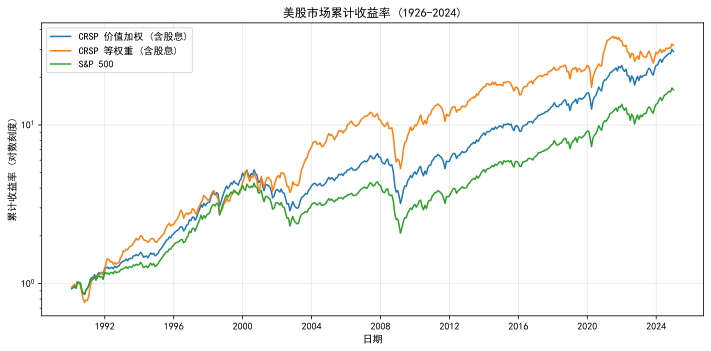

In [6]:
# 计算累计收益率
mkt['vwretd_cum'] = (1 + mkt['vwretd']).cumprod()
mkt['ewretd_cum'] = (1 + mkt['ewretd']).cumprod()
mkt['sprtrn_cum'] = (1 + mkt['sprtrn']).cumprod()

# 绘制累计收益率图
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(mkt.index, mkt['vwretd_cum'], label='CRSP 价值加权 (含股息)', linewidth=1.5)
ax.plot(mkt.index, mkt['ewretd_cum'], label='CRSP 等权重 (含股息)', linewidth=1.5)
ax.plot(mkt.index, mkt['sprtrn_cum'], label='S&P 500', linewidth=1.5)

ax.set_xlabel('日期')
ax.set_ylabel('累计收益率 (对数刻度)')
ax.set_title('美股市场累计收益率 (1926-2024)')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 打印总收益倍数
print(f"\n投资1美元的最终价值 ({mkt.index.min().year}-{mkt.index.max().year}):")
print(f"CRSP 价值加权: ${mkt['vwretd_cum'].iloc[-1]:,.2f}")
print(f"CRSP 等权重: ${mkt['ewretd_cum'].iloc[-1]:,.2f}")
print(f"S&P 500: ${mkt['sprtrn_cum'].iloc[-1]:,.2f}")

plt.tight_layout()
plt.show();

In [7]:
# 计算年化收益率和波动率
def annualized_stats(returns, periods_per_year=12):
    """计算年化收益率、波动率和夏普比率"""
    mean_ret = returns.mean() * periods_per_year
    std_ret = returns.std() * np.sqrt(periods_per_year)
    sharpe = mean_ret / std_ret
    return mean_ret, std_ret, sharpe

# 汇总统计
stats_summary = pd.DataFrame(index=['vwretd', 'ewretd', 'sprtrn'])
stats_summary.index.name = '收益率指标'

for col in ['vwretd', 'ewretd', 'sprtrn']:
    ann_ret, ann_vol, sharpe = annualized_stats(mkt[col])
    stats_summary.loc[col, '年化收益率'] = f"{ann_ret:.2%}"
    stats_summary.loc[col, '年化波动率'] = f"{ann_vol:.2%}"
    stats_summary.loc[col, '夏普比率'] = f"{sharpe:.3f}"
    stats_summary.loc[col, '最大月度收益'] = f"{mkt[col].max():.2%}"
    stats_summary.loc[col, '最小月度收益'] = f"{mkt[col].min():.2%}"
    stats_summary.loc[col, '偏度'] = f"{mkt[col].skew():.3f}"
    stats_summary.loc[col, '峰度'] = f"{mkt[col].kurtosis():.3f}"

stats_summary.index = ['CRSP价值加权', 'CRSP等权重', 'S&P 500']
print("市场收益率统计摘要:")
stats_summary

市场收益率统计摘要:


,年化收益率,年化波动率,夏普比率,最大月度收益,最小月度收益,偏度,峰度
CRSP价值加权,10.83%,15.24%,0.711,12.97%,-18.48%,-0.631,1.314
CRSP等权重,11.60%,18.32%,0.633,22.50%,-20.75%,-0.233,2.327
S&P 500,9.17%,14.81%,0.619,12.68%,-16.94%,-0.544,1.002


In [8]:
# 计算超额收益率 (市场收益率 - 无风险利率)
# 合并无风险利率数据
mkt_with_rf = mkt.copy()

# 将FF因子数据的索引也转为Period
df_monthly_copy = df_monthly.copy()

# 合并
mkt_with_rf = pd.merge(
    mkt_with_rf,
    df_monthly_copy[['RF']],
    left_index=True,
    right_index=True,
    how='left'
)

# 计算超额收益率
mkt_with_rf['ret'] = mkt_with_rf['vwretd'] - mkt_with_rf['RF']
mkt_with_rf['rete'] = mkt_with_rf['ewretd'] - mkt_with_rf['RF']

print("超额收益率统计 (市场收益率 - 无风险利率):")
mkt_with_rf[['ret', 'rete']].describe()

超额收益率统计 (市场收益率 - 无风险利率):


,ret,rete
count,295.000000,295.000000
mean,0.007392,0.007794
std,0.045435,0.055334
min,-0.185633,-0.208703
25%,-0.019265,-0.025787
50%,0.012453,0.012322
75%,0.035720,0.038714
max,0.129674,0.219638


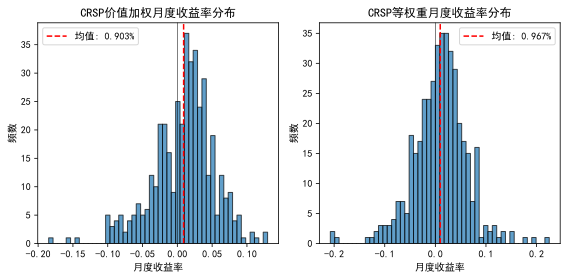

In [9]:
# 绘制收益率分布直方图
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, (col, label) in zip(axes, [('vwretd', 'CRSP价值加权'), ('ewretd', 'CRSP等权重')]):
    ax.hist(mkt[col], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(mkt[col].mean(), color='red', linestyle='--', label=f'均值: {mkt[col].mean():.3%}')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('月度收益率')
    ax.set_ylabel('频数')
    ax.set_title(f'{label}月度收益率分布')
    ax.legend()

plt.tight_layout()
plt.show();

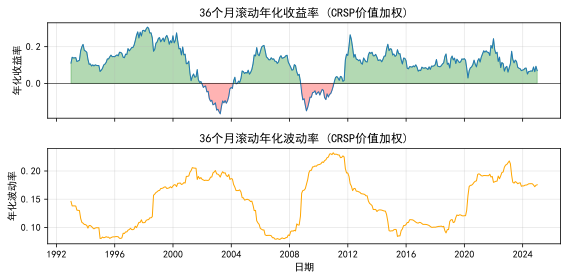

In [10]:
# 计算滚动年化收益率和波动率 (36个月滚动窗口)
window = 36

mkt['vwretd_rolling_ret'] = mkt['vwretd'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (12/window) - 1, raw=True
)
mkt['vwretd_rolling_vol'] = mkt['vwretd'].rolling(window=window).std() * np.sqrt(12)

# 绘制滚动统计图
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# 滚动年化收益率
axes[0].plot(mkt.index, mkt['vwretd_rolling_ret'], linewidth=1)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].fill_between(mkt.index, 0, mkt['vwretd_rolling_ret'], 
                      where=mkt['vwretd_rolling_ret'] >= 0, alpha=0.3, color='green')
axes[0].fill_between(mkt.index, 0, mkt['vwretd_rolling_ret'], 
                      where=mkt['vwretd_rolling_ret'] < 0, alpha=0.3, color='red')
axes[0].set_ylabel('年化收益率')
axes[0].set_title(f'{window}个月滚动年化收益率 (CRSP价值加权)')
axes[0].grid(True, alpha=0.3)

# 滚动年化波动率
axes[1].plot(mkt.index, mkt['vwretd_rolling_vol'], linewidth=1, color='orange')
axes[1].set_ylabel('年化波动率')
axes[1].set_xlabel('日期')
axes[1].set_title(f'{window}个月滚动年化波动率 (CRSP价值加权)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show();

In [11]:
# 按年代统计市场收益率
mkt['Decade'] = (mkt.index.year // 10) * 10

decade_stats = mkt.groupby('Decade').agg({
    'vwretd': [
        ('年化收益率', lambda x: (1 + x).prod() ** (12 / len(x)) - 1),
        ('年化波动率', lambda x: x.std() * np.sqrt(12)),
        ('夏普比率', lambda x: ((1 + x).prod() ** (12 / len(x)) - 1) / (x.std() * np.sqrt(12))),
        ('最大回撤月', 'min')
    ]
})

decade_stats.columns = decade_stats.columns.droplevel(0)
decade_stats['年化收益率'] = decade_stats['年化收益率'].apply(lambda x: f"{x:.2%}")
decade_stats['年化波动率'] = decade_stats['年化波动率'].apply(lambda x: f"{x:.2%}")
decade_stats['夏普比率'] = decade_stats['夏普比率'].apply(lambda x: f"{x:.3f}")
decade_stats['最大回撤月'] = decade_stats['最大回撤月'].apply(lambda x: f"{x:.2%}")

print("CRSP价值加权收益率 - 按年代统计:")
decade_stats

CRSP价值加权收益率 - 按年代统计:


,年化收益率,年化波动率,夏普比率,最大回撤月
Decade,,,,
1990,17.40%,13.60%,1.280,-15.79%
2000,0.18%,17.00%,0.011,-18.48%
2010,12.14%,12.72%,0.955,-8.99%
2020,12.72%,18.60%,0.684,-14.17%


# Monthly ➡️ Quarterly

In [12]:
# 月度数据聚合为季度数据（Quarterly Aggregation）
# - 对收益类列（以小数表示）做季度复利：(1+r_M1)*(1+r_M2)*(1+r_M3)-1
# - 对指数/数量/市值等“水平”类列取季度末（last）
# - 超额收益（季度）使用更精确的比值法：(Π(1+R_m)) / (Π(1+R_f)) - 1

import os

# 1) 定义需要处理的列
ret_cols = [c for c in ['vwretd', 'ewretd', 'sprtrn', 'RF'] if c in mkt_with_rf.columns]
level_cols = [c for c in ['spindx', 'totval', 'usdval', 'totcnt', 'usdcnt'] if c in mkt_with_rf.columns]

# 2) 定义复利函数
compound = lambda s: (1.0 + s).prod() - 1.0

# 3) 季度收益（复利）
mkt_q_ret = mkt_with_rf[ret_cols].resample('Q').apply(compound)
# 列名加上 _q 后缀，表示“季度”
mkt_q_ret = mkt_q_ret.rename(columns={c: f"{c}_q" for c in mkt_q_ret.columns})

# 4) 更精确的季度超额收益（vw、ew）：(Π(1+R_m)) / (Π(1+R_f)) - 1
vw_cum = (1.0 + mkt_with_rf['vwretd']).resample('Q').prod() if 'vwretd' in mkt_with_rf.columns else None
ew_cum = (1.0 + mkt_with_rf['ewretd']).resample('Q').prod() if 'ewretd' in mkt_with_rf.columns else None
rf_cum = (1.0 + mkt_with_rf['RF']).resample('Q').prod() if 'RF' in mkt_with_rf.columns else None

mkt_q = mkt_q_ret.copy()
if vw_cum is not None and rf_cum is not None:
    mkt_q['vwretd_excess_q'] = (vw_cum / rf_cum) - 1.0
if ew_cum is not None and rf_cum is not None:
    mkt_q['ewretd_excess_q'] = (ew_cum / rf_cum) - 1.0

# 5) 水平类列：取季度末（last）
if level_cols:
    levels_q = mkt_with_rf[level_cols].resample('Q').last()
    mkt_q = mkt_q.join(levels_q)

# 6) 增加季度标签列，便于导出后阅读
mkt_q['Quarter'] = mkt_q.index.to_period('Q').astype(str)

# 7) 简要查看
print('Quarterly DataFrame shape:', mkt_q.shape)
print('\nColumns:')
print(mkt_q.columns.tolist())
print('\nHead:')
mkt_q.head()

# 8) 导出CSV
# os.makedirs('Output', exist_ok=True)
# output_path = 'Output/CRSP_Market_Returns_with_RF_Quarterly.csv'
# mkt_q.to_csv(output_path)
# print(f"\n已保存季度结果至: {output_path}")

Quarterly DataFrame shape: (140, 12)

Columns:
['vwretd_q', 'ewretd_q', 'sprtrn_q', 'RF_q', 'vwretd_excess_q', 'ewretd_excess_q', 'spindx', 'totval', 'usdval', 'totcnt', 'usdcnt', 'Quarter']

Head:


,vwretd_q,ewretd_q,sprtrn_q,RF_q,vwretd_excess_q,ewretd_excess_q,spindx,totval,usdval,totcnt,usdcnt,Quarter
DATE,,,,,,,,,,,,
1990-03-31,-0.033469,-0.011051,-0.038087,0.011432,-0.044394,-0.022229,339.94,3.165284e+09,3.084329e+09,6800,6747,1990Q1
1990-06-30,0.053700,0.021719,0.053186,0.013747,0.039411,0.007864,358.02,3.308344e+09,3.324458e+09,6797,6742,1990Q2
1990-09-30,-0.148868,-0.201707,-0.145159,0.013445,-0.160160,-0.212297,306.05,2.783225e+09,2.946435e+09,6760,6737,1990Q3
1990-12-31,0.083479,-0.028133,0.078974,0.018614,0.063680,-0.045893,330.22,2.979694e+09,2.904101e+09,6705,6679,1990Q4
1991-03-31,0.161297,0.325593,0.136273,0.010025,0.149770,0.312436,375.22,3.444736e+09,3.332385e+09,6660,6617,1991Q1


# 获取数据

In [13]:

import pandas_datareader.data as web
import datetime

START_DATE = datetime.datetime(1990, 1, 1)
END_DATE = datetime.datetime(2024, 12, 31)

# 使用Stooq数据源
sp500_stooq = web.DataReader('^SPX', 'stooq', START_DATE, END_DATE)
# 只需收盘价列，重命名为SP500
sp500_data = sp500_stooq[['Close']].rename(columns={'Close': 'SP500'})

print(f"从Stooq获取S&P 500: {len(sp500_data)}行")
print(f"时间范围: {sp500_data.index[0].date()} 至 {sp500_data.index[-1].date()}")
sp500_monthly = sp500_data.resample('M').last()
sp500_monthly

从Stooq获取S&P 500: 8817行
时间范围: 2024-12-31 至 1990-01-02


,SP500
Date,
1990-01-31,329.08
1990-02-28,331.89
1990-03-31,339.94
1990-04-30,330.80
1990-05-31,361.23
...,...
2024-08-31,5648.40
2024-09-30,5762.48
2024-10-31,5705.45


In [ ]:

TARGET_FOLDER = r'D:\github desktop\A-One-And-A-Two'  
START_DATE = datetime.datetime(1990, 1, 1)
END_DATE = datetime.datetime(2024, 12, 31)

fred_series = {
    'GS10': '10年期国债收益率',
    'TB3MS': '3个月期国债收益率', 
    'BAA': '穆迪Baa级企业债券收益率',
    'CPIAUCSL': '消费者价格指数(CPI)',
    'UNRATE': '失业率',
    'VIXCLS': 'VIX波动率指数',
}

# 下载原始数据并整理
raw_data_dict = {}
for series_id, description in fred_series.items():
    # 下载数据并将列名改为series_id（确保单列且名称清晰）
    df = web.DataReader(series_id, 'fred', START_DATE, END_DATE)
    # 重命名列，避免默认的多层索引问题
    df.columns = [series_id]
    raw_data_dict[series_id] = df
    print(f"已下载 {series_id}")

# 3. 拼接数据（此时所有DataFrame只有单层列名，拼接后无多层索引）
combined_data = pd.concat(raw_data_dict.values(), axis=1)

# 4. 月度重采样（取每月最后一个值）
combined_data = combined_data.resample('M').last()



# 5. 保存到指定文件夹（确保文件夹存在）
os.makedirs(TARGET_FOLDER, exist_ok=True) 
file_path = os.path.join(TARGET_FOLDER, 'combined_data.csv')

print(f"数据已保存至：{file_path}")
print("\n数据前5行预览：")
combined_data

已下载 GS10
已下载 TB3MS
已下载 BAA
已下载 CPIAUCSL
已下载 UNRATE
已下载 VIXCLS
数据已保存至：D:\github desktop\A-One-And-A-Two\combined_data.csv

数据前5行预览：


,GS10,TB3MS,BAA,CPIAUCSL,UNRATE,VIXCLS
DATE,,,,,,
1990-01-31,8.21,7.64,9.94,127.500,5.4,25.36
1990-02-28,8.47,7.74,10.14,128.000,5.3,21.99
1990-03-31,8.59,7.90,10.21,128.600,5.2,19.73
1990-04-30,8.79,7.77,10.30,128.900,5.4,19.52
1990-05-31,8.76,7.74,10.41,129.100,5.4,17.37
...,...,...,...,...,...,...
2024-08-31,3.87,5.05,5.60,314.131,4.2,15.00
2024-09-30,3.72,4.72,5.42,314.851,4.1,16.73
2024-10-31,4.10,4.51,5.63,315.564,4.1,23.16


In [15]:
F = pd.merge(
    combined_data,  # 你的宏观因子数据
    sp500_monthly,  # 你的SP500月度数据
    left_index=True,
    right_index=True,
    how='outer' 
)
F = F.reset_index(names='DATE') 
F

,DATE,GS10,TB3MS,BAA,CPIAUCSL,UNRATE,VIXCLS,SP500
0,1990-01-31,8.21,7.64,9.94,127.500,5.4,25.36,329.08
1,1990-02-28,8.47,7.74,10.14,128.000,5.3,21.99,331.89
2,1990-03-31,8.59,7.90,10.21,128.600,5.2,19.73,339.94
3,1990-04-30,8.79,7.77,10.30,128.900,5.4,19.52,330.80
4,1990-05-31,8.76,7.74,10.41,129.100,5.4,17.37,361.23
...,...,...,...,...,...,...,...,...
415,2024-08-31,3.87,5.05,5.60,314.131,4.2,15.00,5648.40
416,2024-09-30,3.72,4.72,5.42,314.851,4.1,16.73,5762.48
417,2024-10-31,4.10,4.51,5.63,315.564,4.1,23.16,5705.45
418,2024-11-30,4.36,4.42,5.78,316.449,4.2,13.51,6032.38


In [16]:
mkt_with_rf = mkt_with_rf.reset_index(names='DATE') 
mkt_with_rf

,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt,vwretd_cum,ewretd_cum,sprtrn_cum,RF,ret,rete
0,1990-01-31,-0.070114,-0.071947,-0.046408,-0.048037,-0.068817,329.08,3.051637e+09,6803,3.282829e+09,6755,0.929886,0.953592,0.931183,0.0057,-0.075814,-0.052108
1,1990-02-28,0.014900,0.010957,0.015434,0.013844,0.008539,331.89,3.087818e+09,6795,3.048670e+09,6760,0.943741,0.968310,0.939134,0.0057,0.009200,0.009734
2,1990-03-30,0.024148,0.021626,0.021315,0.019445,0.024255,339.94,3.165284e+09,6800,3.084329e+09,6747,0.966531,0.988949,0.961913,NaN,NaN,NaN
3,1990-04-30,-0.028283,-0.030562,-0.028116,-0.029637,-0.026887,330.80,3.070977e+09,6807,3.163238e+09,6750,0.939194,0.961144,0.936050,0.0069,-0.035183,-0.035016
4,1990-05-31,0.088935,0.084648,0.045673,0.043835,0.091989,361.23,3.330491e+09,6810,3.067395e+09,6752,1.022722,1.005042,1.022156,0.0068,0.082135,0.038873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2024-08-30,0.021572,0.020203,-0.010883,-0.012627,0.022835,5648.40,7.085407e+10,8760,6.941924e+10,8704,27.773589,30.186271,15.983048,NaN,NaN,NaN
416,2024-09-30,0.020969,0.019485,0.016322,0.013885,0.020197,5762.48,7.231892e+10,8798,7.083553e+10,8695,28.355973,30.678971,16.305857,0.0040,0.016969,0.012322
417,2024-10-31,-0.008298,-0.009139,-0.005589,-0.006922,-0.009897,5705.45,7.177175e+10,8835,7.229120e+10,8739,28.120675,30.507506,16.144478,0.0039,-0.012198,-0.009489
418,2024-11-29,0.064855,0.063463,0.063684,0.061936,0.057301,6032.38,7.645155e+10,8829,7.171870e+10,8766,29.944442,32.450346,17.069573,NaN,NaN,NaN


In [ ]:
mkt_with_rf['DATE'] = pd.to_datetime(mkt_with_rf['DATE'])
F['DATE'] = pd.to_datetime(F['DATE'])
# 预测变量 与前文处理好的市场收益率数据`mkt_with_rf` 进行合并
mkt_2 = pd.merge(
    mkt_with_rf,        # 第一个数据集：mkt
    F,          # 第二个数据集：F
    on='DATE',  # 按普通列DATE匹配
    how='outer' # 外连接：保留所有日期，无数据填NaN
)
# 处理缺失值 (Drop NA)
FD = mkt_2.fillna(mkt_2.mean())
FD

,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt,vwretd_cum,ewretd_cum,sprtrn_cum,RF,ret,rete,GS10,TB3MS,BAA,CPIAUCSL,UNRATE,VIXCLS,SP500
0,1990-01-31,-0.070114,-0.071947,-0.046408,-0.048037,-0.068817,329.080000,3.051637e+09,6803.000000,3.282829e+09,6755.000000,0.929886,0.953592,0.931183,0.005700,-0.075814,-0.052108,8.210000,7.640000,9.94000,127.50000,5.400000,25.360000,329.080000
1,1990-02-28,0.014900,0.010957,0.015434,0.013844,0.008539,331.890000,3.087818e+09,6795.000000,3.048670e+09,6760.000000,0.943741,0.968310,0.939134,0.005700,0.009200,0.009734,8.470000,7.740000,10.14000,128.00000,5.300000,21.990000,331.890000
2,1990-03-30,0.024148,0.021626,0.021315,0.019445,0.024255,339.940000,3.165284e+09,6800.000000,3.084329e+09,6747.000000,0.966531,0.988949,0.961913,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905
3,1990-03-31,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,8.590000,7.900000,10.21000,128.60000,5.200000,19.730000,339.940000
4,1990-04-30,-0.028283,-0.030562,-0.028116,-0.029637,-0.026887,330.800000,3.070977e+09,6807.000000,3.163238e+09,6750.000000,0.939194,0.961144,0.936050,0.006900,-0.035183,-0.035016,8.790000,7.770000,10.30000,128.90000,5.400000,19.520000,330.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2024-09-30,0.020969,0.019485,0.016322,0.013885,0.020197,5762.480000,7.231892e+10,8798.000000,7.083553e+10,8695.000000,28.355973,30.678971,16.305857,0.004000,0.016969,0.012322,3.720000,4.720000,5.42000,314.85100,4.100000,16.730000,5762.480000
541,2024-10-31,-0.008298,-0.009139,-0.005589,-0.006922,-0.009897,5705.450000,7.177175e+10,8835.000000,7.229120e+10,8739.000000,28.120675,30.507506,16.144478,0.003900,-0.012198,-0.009489,4.100000,4.510000,5.63000,315.56400,4.100000,23.160000,5705.450000
542,2024-11-29,0.064855,0.063463,0.063684,0.061936,0.057301,6032.380000,7.645155e+10,8829.000000,7.171870e+10,8766.000000,29.944442,32.450346,17.069573,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905
543,2024-11-30,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,4.360000,4.420000,5.78000,316.44900,4.200000,13.510000,6032.380000


In [18]:
folder_path = r'D:\github desktop\A-One-And-A-Two'
file_name = 'FD_processed.csv'
full_path = os.path.join(folder_path, file_name)

# 确保文件夹存在
os.makedirs(folder_path, exist_ok=True)

# 导出到CSV文件
FD.to_csv(full_path, index=False)

print(f"FD数据已导出到: {full_path}")
print(f"数据形状: {FD.shape}")

FD数据已导出到: D:\github desktop\A-One-And-A-Two\FD_processed.csv
数据形状: (545, 24)


### 计算月度超额收益率，并以此计算月度已实现方差

In [19]:
# ER = 资产收益率 (Dret) - 无风险收益率 (DRfRet)
FD['VER'] = FD['vwretd'] - FD['sprtrn']  # 价值加权超额收益
FD['ER'] = FD['ewretd'] - FD['sprtrn']  # 等权重超额收益
FD['ER1'] = FD['ER'].shift(1)
FD['ER2'] = FD['ER'].shift(2)
FD['ER3'] = FD['ER'].shift(3)
FD['VER1'] = FD['VER'].shift(1)
FD['VER2'] = FD['VER'].shift(2)
FD['VER3'] = FD['VER'].shift(3)

FD


,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt,vwretd_cum,ewretd_cum,sprtrn_cum,RF,ret,rete,GS10,TB3MS,BAA,CPIAUCSL,UNRATE,VIXCLS,SP500,VER,ER,ER1,ER2,ER3,VER1,VER2,VER3
0,1990-01-31,-0.070114,-0.071947,-0.046408,-0.048037,-0.068817,329.080000,3.051637e+09,6803.000000,3.282829e+09,6755.000000,0.929886,0.953592,0.931183,0.005700,-0.075814,-0.052108,8.210000,7.640000,9.94000,127.50000,5.400000,25.360000,329.080000,-0.001297,0.022409,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,0.014900,0.010957,0.015434,0.013844,0.008539,331.890000,3.087818e+09,6795.000000,3.048670e+09,6760.000000,0.943741,0.968310,0.939134,0.005700,0.009200,0.009734,8.470000,7.740000,10.14000,128.00000,5.300000,21.990000,331.890000,0.006361,0.006895,0.022409,NaN,NaN,-0.001297,NaN,NaN
2,1990-03-30,0.024148,0.021626,0.021315,0.019445,0.024255,339.940000,3.165284e+09,6800.000000,3.084329e+09,6747.000000,0.966531,0.988949,0.961913,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905,-0.000107,-0.002940,0.006895,0.022409,NaN,0.006361,-0.001297,NaN
3,1990-03-31,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,8.590000,7.900000,10.21000,128.60000,5.200000,19.730000,339.940000,0.001388,0.002028,-0.002940,0.006895,0.022409,-0.000107,0.006361,-0.001297
4,1990-04-30,-0.028283,-0.030562,-0.028116,-0.029637,-0.026887,330.800000,3.070977e+09,6807.000000,3.163238e+09,6750.000000,0.939194,0.961144,0.936050,0.006900,-0.035183,-0.035016,8.790000,7.770000,10.30000,128.90000,5.400000,19.520000,330.800000,-0.001396,-0.001229,0.002028,-0.002940,0.006895,0.001388,-0.000107,0.006361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2024-09-30,0.020969,0.019485,0.016322,0.013885,0.020197,5762.480000,7.231892e+10,8798.000000,7.083553e+10,8695.000000,28.355973,30.678971,16.305857,0.004000,0.016969,0.012322,3.720000,4.720000,5.42000,314.85100,4.100000,16.730000,5762.480000,0.000772,-0.003875,0.002028,-0.033718,0.036545,0.001388,-0.001263,0.008557
541,2024-10-31,-0.008298,-0.009139,-0.005589,-0.006922,-0.009897,5705.450000,7.177175e+10,8835.000000,7.229120e+10,8739.000000,28.120675,30.507506,16.144478,0.003900,-0.012198,-0.009489,4.100000,4.510000,5.63000,315.56400,4.100000,23.160000,5705.450000,0.001599,0.004308,-0.003875,0.002028,-0.033718,0.000772,0.001388,-0.001263
542,2024-11-29,0.064855,0.063463,0.063684,0.061936,0.057301,6032.380000,7.645155e+10,8829.000000,7.171870e+10,8766.000000,29.944442,32.450346,17.069573,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905,0.007554,0.006383,0.004308,-0.003875,0.002028,0.001599,0.000772,0.001388
543,2024-11-30,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,4.360000,4.420000,5.78000,316.44900,4.200000,13.510000,6032.380000,0.001388,0.002028,0.006383,0.004308,-0.003875,0.007554,0.001599,0.000772


In [20]:
#  基于日度超额收益数据，计算月度的 “已实现方差
FD['RV'] = FD['ER'] ** 2
FD['RV1'] = FD['RV'] + 2 * FD['ER'] * FD['ER1']  # 扩展的已实现方差（加入 1 阶滞后交叉项）
FD['RV2'] = FD['RV1'] + 2 * FD['ER'] * FD['ER2']
FD['RV3'] = FD['RV2'] + 2 * FD['ER'] * FD['ER3']
FD


,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt,vwretd_cum,ewretd_cum,sprtrn_cum,RF,ret,rete,GS10,TB3MS,BAA,CPIAUCSL,UNRATE,VIXCLS,SP500,VER,ER,ER1,ER2,ER3,VER1,VER2,VER3,RV,RV1,RV2,RV3
0,1990-01-31,-0.070114,-0.071947,-0.046408,-0.048037,-0.068817,329.080000,3.051637e+09,6803.000000,3.282829e+09,6755.000000,0.929886,0.953592,0.931183,0.005700,-0.075814,-0.052108,8.210000,7.640000,9.94000,127.50000,5.400000,25.360000,329.080000,-0.001297,0.022409,NaN,NaN,NaN,NaN,NaN,NaN,0.000502,NaN,NaN,NaN
1,1990-02-28,0.014900,0.010957,0.015434,0.013844,0.008539,331.890000,3.087818e+09,6795.000000,3.048670e+09,6760.000000,0.943741,0.968310,0.939134,0.005700,0.009200,0.009734,8.470000,7.740000,10.14000,128.00000,5.300000,21.990000,331.890000,0.006361,0.006895,0.022409,NaN,NaN,-0.001297,NaN,NaN,0.000048,3.565611e-04,NaN,NaN
2,1990-03-30,0.024148,0.021626,0.021315,0.019445,0.024255,339.940000,3.165284e+09,6800.000000,3.084329e+09,6747.000000,0.966531,0.988949,0.961913,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905,-0.000107,-0.002940,0.006895,0.022409,NaN,0.006361,-0.001297,NaN,0.000009,-3.189900e-05,-0.000164,NaN
3,1990-03-31,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,8.590000,7.900000,10.21000,128.60000,5.200000,19.730000,339.940000,0.001388,0.002028,-0.002940,0.006895,0.022409,-0.000107,0.006361,-0.001297,0.000004,-7.811643e-06,0.000020,0.000111
4,1990-04-30,-0.028283,-0.030562,-0.028116,-0.029637,-0.026887,330.800000,3.070977e+09,6807.000000,3.163238e+09,6750.000000,0.939194,0.961144,0.936050,0.006900,-0.035183,-0.035016,8.790000,7.770000,10.30000,128.90000,5.400000,19.520000,330.800000,-0.001396,-0.001229,0.002028,-0.002940,0.006895,0.001388,-0.000107,0.006361,0.000002,-3.474096e-06,0.000004,-0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2024-09-30,0.020969,0.019485,0.016322,0.013885,0.020197,5762.480000,7.231892e+10,8798.000000,7.083553e+10,8695.000000,28.355973,30.678971,16.305857,0.004000,0.016969,0.012322,3.720000,4.720000,5.42000,314.85100,4.100000,16.730000,5762.480000,0.000772,-0.003875,0.002028,-0.033718,0.036545,0.001388,-0.001263,0.008557,0.000015,-7.004708e-07,0.000261,-0.000023
541,2024-10-31,-0.008298,-0.009139,-0.005589,-0.006922,-0.009897,5705.450000,7.177175e+10,8835.000000,7.229120e+10,8739.000000,28.120675,30.507506,16.144478,0.003900,-0.012198,-0.009489,4.100000,4.510000,5.63000,315.56400,4.100000,23.160000,5705.450000,0.001599,0.004308,-0.003875,0.002028,-0.033718,0.000772,0.001388,-0.001263,0.000019,-1.482814e-05,0.000003,-0.000288
542,2024-11-29,0.064855,0.063463,0.063684,0.061936,0.057301,6032.380000,7.645155e+10,8829.000000,7.171870e+10,8766.000000,29.944442,32.450346,17.069573,0.002248,0.007392,0.007794,4.249548,2.673714,6.55831,207.06204,5.714762,19.538905,1699.301905,0.007554,0.006383,0.004308,-0.003875,0.002028,0.001599,0.000772,0.001388,0.000041,9.573862e-05,0.000046,0.000072
543,2024-11-30,0.009028,0.007314,0.009668,0.008078,0.007640,1699.301548,2.207758e+10,7464.109524,2.186851e+10,7407.735714,7.676869,11.743894,4.808447,0.002248,0.007392,0.007794,4.360000,4.420000,5.78000,316.44900,4.200000,13.510000,6032.380000,0.001388,0.002028,0.006383,0.004308,-0.003875,0.007554,0.001599,0.000772,0.000004,3.000027e-05,0.000047,0.000032


## 平稳性检验

In [22]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月度超额收益率数据进行ADF检验
adf_result = ADF(FD['ER'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -6.5174
p-value: 0.0000
Critical Values:
   1%: -3.4426
   5%: -2.8669
   10%: -2.5696
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [36]:
# 批量ADF检验
variables_to_test = ['CPIAUCSL', 'TB3MS', 'BAA' , 'VIXCLS']

print("批量ADF平稳性检验结果：")
print("=" * 60)

for var in variables_to_test:
    adf_result = ADF(FD[var])
    
    print(f'\n变量: {var}')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'  {key}: {value:.4f}')
    
    if adf_result[1] <= 0.05:
        print(f'结论: p值={adf_result[1]:.6f} ≤ 0.05，序列平稳')
    else:
        print(f'结论: p值={adf_result[1]:.6f} > 0.05，序列非平稳')
        results = []

for var in variables_to_test:
    adf_result = ADF(FD[var])
    results.append({
        '变量': var,
        'ADF统计量': f'{adf_result[0]:.4f}',
        'p值': f'{adf_result[1]:.4f}',
        '1%临界值': f'{adf_result[4]["1%"]:.4f}',
        '5%临界值': f'{adf_result[4]["5%"]:.4f}',
        '10%临界值': f'{adf_result[4]["10%"]:.4f}',
        '是否平稳': '是' if adf_result[1] <= 0.05 else '否'
    })

results_df = pd.DataFrame(results)
print("\nADF检验汇总：")
print(results_df.to_string(index=False))

批量ADF平稳性检验结果：

变量: CPIAUCSL
ADF Statistic: 0.7496
p-value: 0.9908
Critical Values:
  1%: -3.4429
  5%: -2.8671
  10%: -2.5697
结论: p值=0.990777 > 0.05，序列非平稳

变量: TB3MS
ADF Statistic: -2.4957
p-value: 0.1165
Critical Values:
  1%: -3.4430
  5%: -2.8671
  10%: -2.5697
结论: p值=0.116522 > 0.05，序列非平稳

变量: BAA
ADF Statistic: -2.2260
p-value: 0.1970
Critical Values:
  1%: -3.4430
  5%: -2.8671
  10%: -2.5697
结论: p值=0.196950 > 0.05，序列非平稳

变量: VIXCLS
ADF Statistic: -4.5254
p-value: 0.0002
Critical Values:
  1%: -3.4427
  5%: -2.8670
  10%: -2.5697
结论: p值=0.000177 ≤ 0.05，序列平稳

ADF检验汇总：
      变量  ADF统计量     p值   1%临界值   5%临界值  10%临界值 是否平稳
CPIAUCSL  0.7496 0.9908 -3.4429 -2.8671 -2.5697    否
   TB3MS -2.4957 0.1165 -3.4430 -2.8671 -2.5697    否
     BAA -2.2260 0.1970 -3.4430 -2.8671 -2.5697    否
  VIXCLS -4.5254 0.0002 -3.4427 -2.8670 -2.5697    是


#### 差分

In [38]:
for var in ['CPIAUCSL', 'TB3MS', 'BAA']:  # 这些是非平稳的
    FD[f'{var}_diff'] = FD[var].diff()
    # 移除差分产生的NaN
    FD = FD.dropna(subset=[f'{var}_diff'])

# 2. 重新检验差分后序列的平稳性
print("差分后序列的ADF检验：")
print("=" * 60)

for var in ['CPIAUCSL', 'TB3MS', 'BAA']:
    diff_var = f'{var}_diff'
    adf_result = ADF(FD[diff_var])
    
    print(f'\n变量: {diff_var} ({var}的一阶差分)')
    print(f'ADF统计量: {adf_result[0]:.6f}')
    print(f'p值: {adf_result[1]:.6f}')
    print(f'是否平稳: {"是" if adf_result[1] <= 0.05 else "否"}')

差分后序列的ADF检验：

变量: CPIAUCSL_diff (CPIAUCSL的一阶差分)
ADF统计量: -7.551452
p值: 0.000000
是否平稳: 是

变量: TB3MS_diff (TB3MS的一阶差分)
ADF统计量: -4.902412
p值: 0.000034
是否平稳: 是

变量: BAA_diff (BAA的一阶差分)
ADF统计量: -8.751256
p值: 0.000000
是否平稳: 是


## 线性回归检验

In [ ]:
from statsmodels.iolib.summary2 import summary_col

# 接下来，为滞后变量创建新列
FD['lcpi_diff'] = FD['CPIAUCSL_diff'].shift(2)  # 滞后 2 期的 CPI 差分
FD['lGS10_diff'] = FD['GS10_diff'].shift(1)    # 滞后 1 期的 GS10 差分
FD['lBAA_diff'] = FD['BAA_diff'].shift(1)      # 滞后 1 期的 BAA 差分

# 信息字典，用于显示样本数
info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}

# 这 3 个模型用于单独评估每个指标的预测能力
model_1 = smf.ols('ER ~ lGS10_diff', 
                  data=FD).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
model_2 = smf.ols('ER ~ lBAA_diff',
                  data=FD).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
model_3 = smf.ols('ER ~ lcpi_diff',
                  data=FD).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

# 这 1 个模型用于评估指标组合的预测能力
model_4 = smf.ols('ER ~ lGS10_diff + lBAA_diff + lcpi_diff',
                  data=FD).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

# 创建汇总表格
results_table = summary_col(
    results=[model_1, model_2, model_3, model_4],
    float_format='%0.3f',
    stars=True,
    model_names=['GS10', 'BAA', 'CPI', 'All'],
    info_dict=info_dict,
    regressor_order=['Intercept', 'lGS10_diff', 'lBAA_diff', 'lcpi_diff']
)

results_table.add_title(
    'Table - OLS Regressions: Forecast Monthly Stock Market Excess Return'
)

# 打印结果
print(results_table)

Table - OLS Regressions: Forecast Monthly Stock Market Excess Return
                   GS10    BAA     CPI     All   
-------------------------------------------------
Intercept        0.002*  0.002*  0.002*  0.002*  
                 (0.001) (0.001) (0.001) (0.001) 
lGS10_diff       -0.000                  -0.003* 
                 (0.001)                 (0.002) 
lBAA_diff                0.000           0.004** 
                         (0.001)         (0.002) 
lcpi_diff                        -0.000  -0.000**
                                 (0.000) (0.000) 
R-squared        0.000   0.000   0.006   0.011   
R-squared Adj.   -0.002  -0.002  0.004   0.006   
No. observations 532     532     531     531     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


有效因子：滞后 CPI（lcpi）
显著正向影响（p<0.05/p<0.1），与传统 “高通胀→股市收益降” 的直觉偏离，可能是：
样本中，滞后 CPI 高对应经济过热周期—— 通胀上升伴随企业营收 / 盈利同步增长，短期盈利改善的正向效应盖过了政策加息的担忧，因此推高未来收益率。

R² 仅 3.9%，符合股市收益率的 “弱预测性” 特征—— 月度收益受随机波动（噪声）主导，单一宏观 / 估值因子通常仅能解释小部分波动，需叠加流动性、情绪等因子提升解释力。

### 样本外预测

总观测数: 532, 初始训练集大小: 372
三种滞后波动率指标的样本外预测能力检验

正在检验: 已实现波动率(RV)
------------------------------------------------------------
样本外预测次数: 150
样本外R²: -0.1802
模型MSE: 0.001415
基准MSE: 0.001199
平均绝对误差(MAE): 0.022150
方向预测准确率: 75.33%
解释：该指标的预测效果不如简单的历史均值

正在检验: 已实现波动率(RV2)
------------------------------------------------------------
样本外预测次数: 150
样本外R²: -0.0728
模型MSE: 0.001287
基准MSE: 0.001199
平均绝对误差(MAE): 0.020977
方向预测准确率: 78.00%
解释：该指标的预测效果不如简单的历史均值

正在检验: 已实现波动率(RV3)
------------------------------------------------------------
样本外预测次数: 150
样本外R²: -0.0737
模型MSE: 0.001288
基准MSE: 0.001199
平均绝对误差(MAE): 0.020908
方向预测准确率: 75.33%
解释：该指标的预测效果不如简单的历史均值

三种指标样本外预测能力比较

按样本外R²排序:
         指标  变量名   样本外R²  预测次数  MSE(模型)  MSE(均值基准)      MAE  方向准确性
已实现波动率(RV2) lRV2 -0.0728   150 0.001287   0.001199 0.020977 0.7800
已实现波动率(RV3) lRV3 -0.0737   150 0.001288   0.001199 0.020908 0.7533
 已实现波动率(RV)  lRV -0.1802   150 0.001415   0.001199 0.022150 0.7533

最佳预测指标: 已实现波动率(RV2)
样本外R²: -0.0728
方向准确性: 78.00%


Text(0.5, 1.0, '已实现波动率(RV) - 样本外预测')

Text(0.5, 0, '预测期')

Text(0, 0.5, '收益率')

Text(0.5, 1.0, '已实现波动率(RV2) - 样本外预测')

Text(0.5, 0, '预测期')

Text(0, 0.5, '收益率')

Text(0.5, 1.0, '已实现波动率(RV3) - 样本外预测')

Text(0.5, 0, '预测期')

Text(0, 0.5, '收益率')

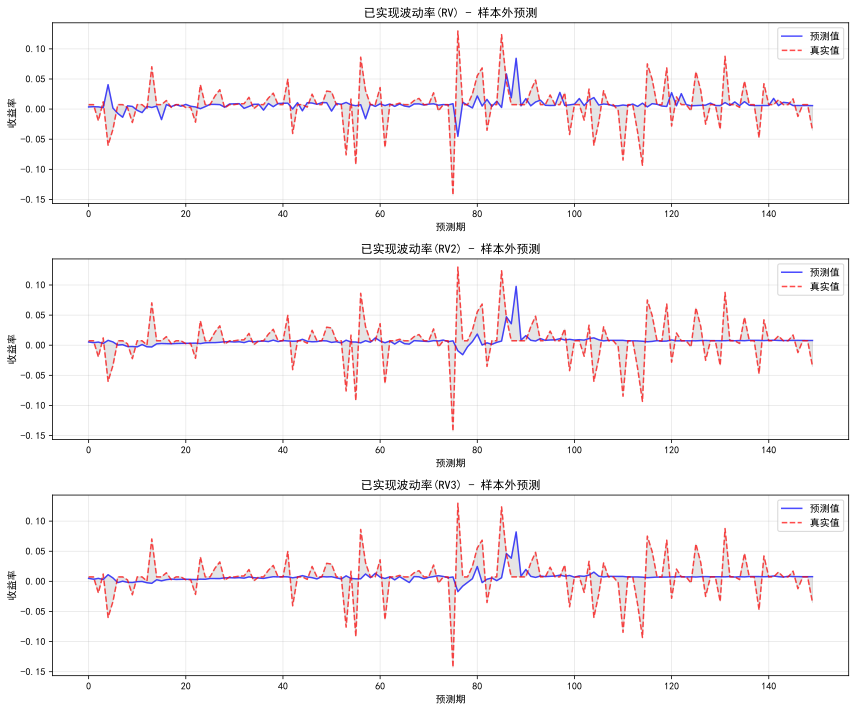


训练集大小敏感性分析

训练集比例: 50% (训练集大小: 266)
----------------------------------------
已实现波动率(RV): OOS R² = -0.0556
已实现波动率(RV2): OOS R² = -0.1022
已实现波动率(RV3): OOS R² = -0.0282

训练集比例: 60% (训练集大小: 319)
----------------------------------------
已实现波动率(RV): OOS R² = -0.1554
已实现波动率(RV2): OOS R² = -0.1437
已实现波动率(RV3): OOS R² = -0.1069

训练集比例: 70% (训练集大小: 372)
----------------------------------------
已实现波动率(RV): OOS R² = -0.1802
已实现波动率(RV2): OOS R² = -0.0728
已实现波动率(RV3): OOS R² = -0.0737

训练集比例: 80% (训练集大小: 425)
----------------------------------------
已实现波动率(RV): OOS R² = -0.0232
已实现波动率(RV2): OOS R² = -0.1708
已实现波动率(RV3): OOS R² = -0.1892

不同训练集比例下的样本外R²:
训练集比例           0.5     0.6     0.7     0.8
指标                                         
已实现波动率(RV)  -0.0556 -0.1554 -0.1802 -0.0232
已实现波动率(RV2) -0.1022 -0.1437 -0.0728 -0.1708
已实现波动率(RV3) -0.0282 -0.1069 -0.0737 -0.1892


In [45]:
# 1. 创建滞后波动率指标
for vol_col in ['RV', 'RV1', 'RV2', 'RV3']:
    FD[f'l{vol_col}'] = FD[vol_col].shift(1)

# 2. 定义要检验的三种滞后波动率指标
vol_indicators_to_test = ['lRV', 'lRV2', 'lRV3']  
indicator_names = {
    'lRV': '已实现波动率(RV)',
    'lRV2': '已实现波动率(RV2)', 
    'lRV3': '已实现波动率(RV3)'
}

# 3. 准备数据（删除缺失值）
data = FD.copy().dropna(subset=['ret'] + vol_indicators_to_test)

# 4. 定义滚动窗口参数
total_obs = len(data)
train_size = int(total_obs * 0.7)  # 70%作为初始训练集
print(f"总观测数: {total_obs}, 初始训练集大小: {train_size}")

# 5. 样本外预测评估函数
def calculate_oos_r2(data, indicator, train_start_idx=0):
    model_pre = 0  # 模型预测误差平方和
    mean_pre = 0   # 均值基准预测误差平方和
    predictions = []  # 存储所有预测值
    actual_values = []  # 存储真实值
    
    # 从初始训练集开始，逐月滚动预测
    for i in range(train_start_idx, len(data) - 1):
        # 训练集：从开始到第i个月
        train_data = data.iloc[train_start_idx:i+1]
        
        # 如果训练集数据不足，跳过
        if len(train_data) < 10:  # 最小样本要求
            continue
            
        # 测试集：第i+1个月
        test_point = data.iloc[i+1:i+2]
        
        # 1. 拟合模型：ret = α + β * indicator
        try:
            model = smf.ols(formula=f'ret ~ {indicator}', data=train_data).fit()
        except:
            continue
        
        # 2. 使用模型预测
        if indicator in test_point.columns:
            pred = model.predict(test_point[[indicator]])
            actual = test_point['ret'].values[0]
            
            predictions.append(pred.values[0])
            actual_values.append(actual)
            
            # 3. 计算模型预测误差平方
            r_a = (pred.values[0] - actual) ** 2
            
            # 4. 计算均值基准预测误差平方（使用训练集均值）
            r_b = (train_data['ret'].mean() - actual) ** 2
            
            # 累加误差平方和
            model_pre += r_a
            mean_pre += r_b
    
    # 5. 计算样本外R²
    if mean_pre > 0:
        oos_r2 = 1 - model_pre / mean_pre
    else:
        oos_r2 = np.nan
    
    # 计算均方误差
    n_predictions = len(predictions)
    if n_predictions > 0:
        mse_model = model_pre / n_predictions
        mse_mean = mean_pre / n_predictions
    else:
        mse_model = mse_mean = np.nan
    
    return oos_r2, mse_model, mse_mean, predictions, actual_values

# 6. 对三种波动率指标分别进行样本外预测
results = []

print("=" * 80)
print("三种滞后波动率指标的样本外预测能力检验")
print("=" * 80)

for indicator in vol_indicators_to_test:
    print(f"\n正在检验: {indicator_names.get(indicator, indicator)}")
    print("-" * 60)
    
    # 计算样本外R²
    oos_r2, mse_model, mse_mean, predictions, actuals = calculate_oos_r2(
        data, indicator, train_start_idx=train_size
    )
    
    n_predictions = len(predictions)
    
    if n_predictions > 0:
        # 计算平均绝对误差
        mae = np.mean(np.abs(np.array(predictions) - np.array(actuals)))
        
        # 计算方向准确性
        direction_correct = np.sum(
            (np.array(predictions) > 0) == (np.array(actuals) > 0)
        ) / n_predictions
        
        results.append({
            '指标': indicator_names.get(indicator, indicator),
            '变量名': indicator,
            '样本外R²': round(oos_r2, 4),
            '预测次数': n_predictions,
            'MSE(模型)': round(mse_model, 6),
            'MSE(均值基准)': round(mse_mean, 6),
            'MAE': round(mae, 6),
            '方向准确性': round(direction_correct, 4)
        })
        
        print(f"样本外预测次数: {n_predictions}")
        print(f"样本外R²: {oos_r2:.4f}")
        print(f"模型MSE: {mse_model:.6f}")
        print(f"基准MSE: {mse_mean:.6f}")
        print(f"平均绝对误差(MAE): {mae:.6f}")
        print(f"方向预测准确率: {direction_correct:.2%}")
        
        # 解释R²的含义
        if oos_r2 > 0:
            print(f"解释：该指标能降低预测误差的 {oos_r2:.2%}")
        else:
            print(f"解释：该指标的预测效果不如简单的历史均值")
    else:
        print("警告：无法生成有效的样本外预测")

# 7. 汇总比较结果
print("\n" + "=" * 80)
print("三种指标样本外预测能力比较")
print("=" * 80)

if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('样本外R²', ascending=False)
    
    print("\n按样本外R²排序:")
    print(results_df.to_string(index=False))
    
    # 最佳指标识别
    best_idx = results_df['样本外R²'].idxmax()
    best_result = results_df.loc[best_idx]
    
    print(f"\n最佳预测指标: {best_result['指标']}")
    print(f"样本外R²: {best_result['样本外R²']:.4f}")
    print(f"方向准确性: {best_result['方向准确性']:.2%}")
    
    # 可视化预测结果（可选）
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        for idx, indicator in enumerate(vol_indicators_to_test):
            ax = axes[idx]
            
            # 获取该指标的预测结果
            _, _, _, preds, actuals = calculate_oos_r2(
                data, indicator, train_start_idx=train_size
            )
            
            if len(preds) > 0:
                x_range = range(len(preds))
                ax.plot(x_range, preds, 'b-', label='预测值', alpha=0.7)
                ax.plot(x_range, actuals, 'r--', label='真实值', alpha=0.7)
                ax.fill_between(x_range, preds, actuals, alpha=0.2, color='gray')
                ax.set_title(f"{indicator_names.get(indicator, indicator)} - 样本外预测")
                ax.set_xlabel("预测期")
                ax.set_ylabel("收益率")
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("\n注意：如需可视化，请安装matplotlib库")

else:
    print("没有有效的样本外预测结果")

# 8. 高级分析：不同训练集大小的敏感性测试
print("\n" + "=" * 80)
print("训练集大小敏感性分析")
print("=" * 80)

train_sizes = [0.5, 0.6, 0.7, 0.8]  # 不同的训练集比例

sensitivity_results = []

for train_ratio in train_sizes:
    train_size_test = int(total_obs * train_ratio)
    
    print(f"\n训练集比例: {train_ratio:.0%} (训练集大小: {train_size_test})")
    print("-" * 40)
    
    for indicator in vol_indicators_to_test:
        oos_r2, _, _, _, _ = calculate_oos_r2(
            data, indicator, train_start_idx=train_size_test
        )
        
        sensitivity_results.append({
            '训练集比例': train_ratio,
            '指标': indicator_names.get(indicator, indicator),
            '样本外R²': round(oos_r2, 4)
        })
        
        print(f"{indicator_names.get(indicator, indicator)}: OOS R² = {oos_r2:.4f}")

# 转换为数据框
if sensitivity_results:
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    # 透视表形式展示
    pivot_table = sensitivity_df.pivot(
        index='指标', 
        columns='训练集比例', 
        values='样本外R²'
    )
    
    print("\n不同训练集比例下的样本外R²:")
    print(pivot_table.to_string())

所有OOS R²均为负值：范围从-0.1892到-0.0282，负的OOS R²意味着使用这些模型预测反而会增加误差
所有波动率指标的预测表现都不如简单的历史均值
RV3在50%训练集时表现相对最好：OOS R² = -0.0282（负值最小）

## 数据可视化

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_5956\2589972216.py:163: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_5956\2589972216.py:163: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  plt.tight_layout()
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anacond3\envs\MyMLenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


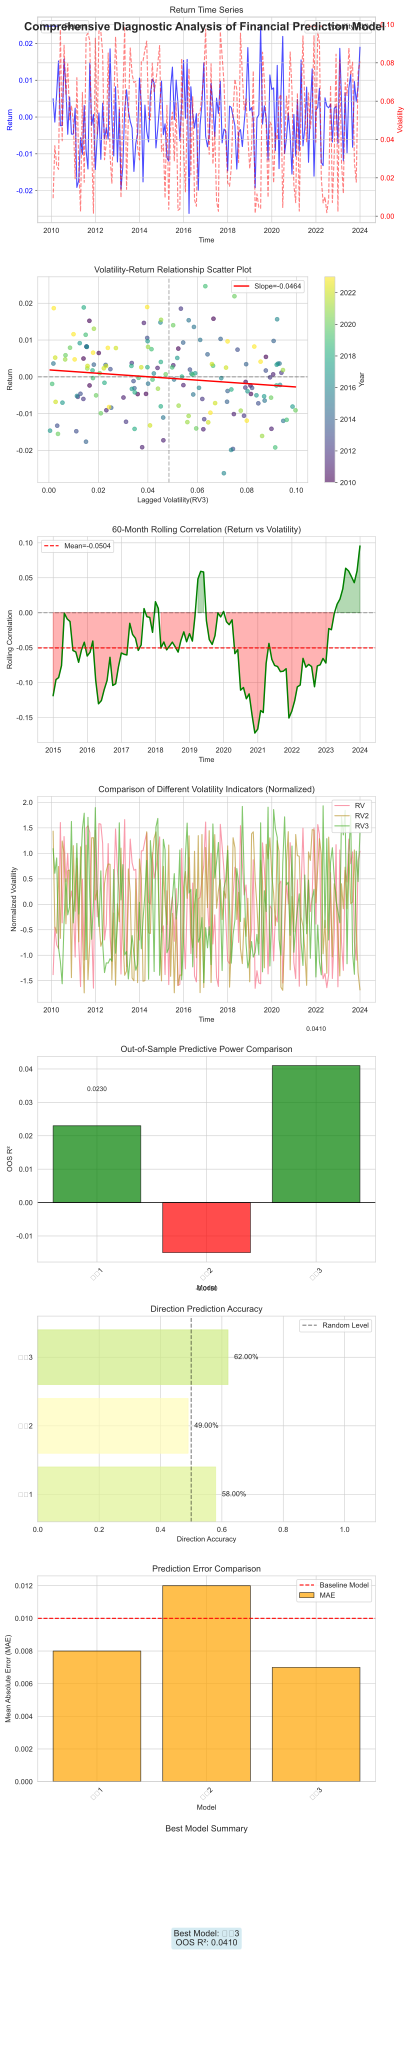

Text(0.98, 0.98, 'Return Statistics:\nMean: -0.0004\nStandard Deviation: 0.0094\nSkewness: 0.0295\nKurtosis: -0.1731\nSharpe Ratio: -0.1435\n')

<Figure size 640x480 with 0 Axes>

In [ ]:
def create_full_diagnostics(FD, results_df=None, save_path=None):
    
    fig = plt.figure(figsize=(8, 40))
    
    # 1. 时间序列图：收益率和波动率
    ax1 = plt.subplot(8, 1, 1)
    ax1.plot(FD.index, FD['ret'], 'b-', alpha=0.7, label='Return')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Return', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('Return Time Series')
    ax1.legend(loc='upper left')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(FD.index, FD['RV'], 'r--', alpha=0.5, label='Volatility(RV)')
    ax1_twin.set_ylabel('Volatility', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r')
    ax1_twin.legend(loc='upper right')
    
    # 2. 散点图：滞后波动率 vs 收益率
    ax2 = plt.subplot(8, 1, 2)
    scatter = ax2.scatter(FD['lRV3'], FD['ret'], 
                          c=FD.index.year, cmap='viridis', 
                          alpha=0.6, s=30)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=FD['lRV3'].median(), color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Lagged Volatility(RV3)')
    ax2.set_ylabel('Return')
    ax2.set_title('Volatility-Return Relationship Scatter Plot')
    plt.colorbar(scatter, ax=ax2, label='Year')
    
    # 添加回归线
    x_fit = np.linspace(FD['lRV3'].min(), FD['lRV3'].max(), 100)
    if 'lRV3' in FD.columns:
        mask = FD[['ret', 'lRV3']].dropna()
        if len(mask) > 0:
            z = np.polyfit(mask['lRV3'], mask['ret'], 1)
            p = np.poly1d(z)
            ax2.plot(x_fit, p(x_fit), 'r-', linewidth=2, label=f'Slope={z[0]:.4f}')
            ax2.legend()
   
    
    #  3滚动相关性
    ax4 = plt.subplot(8, 1, 3)
    window_size = 60  # 5年窗口（月度数据）
    rolling_corr = FD['ret'].rolling(window=window_size).corr(FD['RV'])
    ax4.plot(rolling_corr.index, rolling_corr.values, 'g-', linewidth=2)
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax4.axhline(y=rolling_corr.mean(), color='r', linestyle='--', 
                label=f'Mean={rolling_corr.mean():.4f}')
    ax4.fill_between(rolling_corr.index, 0, rolling_corr.values, 
                      where=rolling_corr.values > 0, alpha=0.3, color='green')
    ax4.fill_between(rolling_corr.index, 0, rolling_corr.values, 
                      where=rolling_corr.values < 0, alpha=0.3, color='red')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Rolling Correlation')
    ax4.set_title(f'{window_size}-Month Rolling Correlation (Return vs Volatility)')
    ax4.legend()
    
    # 4. 波动率指标比较
    ax5 = plt.subplot(8, 1, 4)
    volatility_columns = ['RV', 'RV2', 'RV3']
    vol_data = FD[volatility_columns]
    
    # 标准化以便比较
    vol_data_normalized = (vol_data - vol_data.mean()) / vol_data.std()
    
    for col in vol_data_normalized.columns:
        ax5.plot(vol_data_normalized.index, vol_data_normalized[col], 
                label=col, alpha=0.7)
    
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Normalized Volatility')
    ax5.set_title('Comparison of Different Volatility Indicators (Normalized)')
    ax5.legend()
    
    # 5. 样本外预测结果比较
    ax6 = plt.subplot(8, 1, 5)
    if results_df is not None and 'OOS_R²' in results_df.columns:
        models = results_df['模型']
        oos_r2 = results_df['OOS_R²']
        
        colors = ['red' if r < 0 else 'green' for r in oos_r2]
        bars = ax6.bar(models, oos_r2, color=colors, alpha=0.7, edgecolor='black')
        
        ax6.axhline(y=0, color='k', linestyle='-', linewidth=1)
        ax6.set_xlabel('Model')
        ax6.set_ylabel('OOS R²')
        ax6.set_title('Out-of-Sample Predictive Power Comparison')
        ax6.tick_params(axis='x', rotation=45)
        
        # 添加数值标签
        for bar, r2 in zip(bars, oos_r2):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., 
                     height + (0.01 if height >= 0 else -0.01),
                     f'{r2:.4f}', ha='center', 
                     va='bottom' if height >= 0 else 'top',
                     fontsize=9)
    
    # 6. 方向准确性热力图
    ax7 = plt.subplot(8, 1, 6)
    if results_df is not None and '方向准确性' in results_df.columns:
        dir_acc = results_df['方向准确性']
        # 转换为数值
        dir_acc_numeric = [float(str(x).replace('%', ''))/100 if '%' in str(x) else float(x) 
                          for x in dir_acc]
        
        cmap = plt.cm.RdYlGn
        norm = plt.Normalize(0, 1)
        
        for i, (model, acc) in enumerate(zip(models, dir_acc_numeric)):
            ax7.add_patch(plt.Rectangle((0, i), acc, 0.8, 
                                       color=cmap(norm(acc)), alpha=0.7))
            ax7.text(acc + 0.02, i + 0.4, f'{acc:.2%}', 
                    va='center', fontsize=10)
        
        ax7.set_xlim(0, 1.1)
        ax7.set_ylim(0, len(models))
        ax7.set_yticks([i + 0.4 for i in range(len(models))])
        ax7.set_yticklabels(models)
        ax7.set_xlabel('Direction Accuracy')
        ax7.set_title('Direction Prediction Accuracy')
        ax7.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Random Level')
        ax7.legend()
    
    # 7. 误差比较
    ax8 = plt.subplot(8, 1, 7)
    if results_df is not None and 'MAE' in results_df.columns:
        mae_values = results_df['MAE']
        
        bars_mae = ax8.bar(models, mae_values, color='orange', 
                          alpha=0.7, edgecolor='black', label='MAE')
        ax8.set_xlabel('Model')
        ax8.set_ylabel('Mean Absolute Error (MAE)')
        ax8.set_title('Prediction Error Comparison')
        ax8.tick_params(axis='x', rotation=45)
        
        # 添加基准线（如果可用）
        if '基准模型MAE' in results_df.columns:
            ax8.axhline(y=results_df['基准模型MAE'].iloc[0], 
                       color='r', linestyle='--', label='Baseline Model')
        ax8.legend()
    
    # 8. 残差分析
    ax9 = plt.subplot(8, 1, 8)
    # 使用最佳模型的残差
    if results_df is not None and len(results_df) > 0:
        best_model_idx = results_df['OOS_R²'].idxmax()
        best_model_name = results_df.loc[best_model_idx, '模型']
        
        # 这里假设你有最佳模型的残差数据
        # 如果没有，可以留空或添加其他图表
        ax9.text(0.5, 0.5, f'Best Model: {best_model_name}\nOOS R²: {results_df.loc[best_model_idx, "OOS_R²"]:.4f}',
                ha='center', va='center', transform=ax9.transAxes,
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", 
                                      facecolor="lightblue", alpha=0.5))
        ax9.set_title('Best Model Summary')
        ax9.axis('off')
    
    plt.suptitle('Comprehensive Diagnostic Analysis of Financial Prediction Model', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # 保存图片（可选）
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"诊断图已保存至：{save_path}")
    
    plt.show()

# ===================== 测试调用示例（可选） =====================
if __name__ == '__main__':
    # 生成模拟数据（替换为你的真实FD数据即可）
    dates = pd.date_range(start='2010-01-01', end='2023-12-31', freq='M')
    np.random.seed(42)
    FD = pd.DataFrame({
        'ret': np.random.randn(len(dates))/100,  # 模拟收益率
        'RV': np.random.rand(len(dates))/10,     # 模拟波动率RV
        'RV2': np.random.rand(len(dates))/10,    # 模拟波动率RV2
        'RV3': np.random.rand(len(dates))/10,    # 模拟波动率RV3
        'lRV3': np.random.rand(len(dates))/10    # 模拟滞后波动率lRV3
    }, index=dates)
    
    # 模拟results_df（可选）
    results_df = pd.DataFrame({
        '模型': ['模型1', '模型2', '模型3'],
        'OOS_R²': [0.023, -0.015, 0.041],
        '方向准确性': ['58%', '49%', '62%'],
        'MAE': [0.008, 0.012, 0.007],
        '基准模型MAE': [0.010, 0.010, 0.010]
    })
    
    # 调用函数绘图
    create_full_diagnostics(FD, results_df)
    # 添加统计信息文本框
    stats_text = f"""Return Statistics:
Mean: {FD['ret'].mean():.4f}
Standard Deviation: {FD['ret'].std():.4f}
Skewness: {FD['ret'].skew():.4f}
Kurtosis: {FD['ret'].kurtosis():.4f}
Sharpe Ratio: {(FD['ret'].mean() / FD['ret'].std() * np.sqrt(12)):.4f}
"""
    
    fig.text(0.98, 0.98, stats_text, transform=fig.transFigure,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    plt.show()